$$ \delta_{gn} = -(J^T J)^{-1} J^T f(x) $$
$$ \delta_{sd} = -J^T f(x) $$
$$ J = \begin{pmatrix} \dfrac{\partial{f_1}}{\partial{\beta_1}} & \ldots & \dfrac{\partial{f_1}}{\partial{\beta_p}} \\ \vdots & \ddots & \vdots \\
 \dfrac{\partial{f_n}}{\partial{\beta_1}} & \ldots &\dfrac{\partial{f_n}}{\partial{\beta_p}}
 \end{pmatrix}, ~ f(x) = \begin{pmatrix} f_1 \\ \vdots \\ f_n \end{pmatrix}, ~ f_i = f(x_i, \beta)
$$

dog-leg: [-0.56053736 -0.57078706]
new parameter is: [2.43946264 3.42921294]

dog-leg: [-0.14908205 -0.37117993]
new parameter is: [2.29038059 3.05803301]

dog-leg: [-0.14399887 -0.13879598]
new parameter is: [2.14638172 2.91923703]

dog-leg: [-0.04123525  0.09110244]
new parameter is: [2.10514647 3.01033946]

dog-leg: [-0.04990571 -0.00306916]
new parameter is: [2.05524076 3.0072703 ]

dog-leg: [-0.0241142   0.00659585]
new parameter is: [2.03112655 3.01386615]

dog-leg: [-0.01233314  0.00203558]
new parameter is: [2.01879341 3.01590173]

dog-leg: [-0.00616754  0.00101191]
new parameter is: [2.01262587 3.01691365]

dog-leg: [-0.00308359  0.00050705]
new parameter is: [2.00954228 3.0174207 ]

dog-leg: [-0.00154172  0.00025397]
new parameter is: [2.00800056 3.01767467]

dog-leg: [-0.00077084  0.00012711]
new parameter is: [2.00722972 3.01780178]

dog-leg: [-3.85414656e-04  6.35880013e-05]
new parameter is: [2.00684431 3.01786537]

dog-leg: [-1.92705924e-04  3.18025092e-05]
new parameter

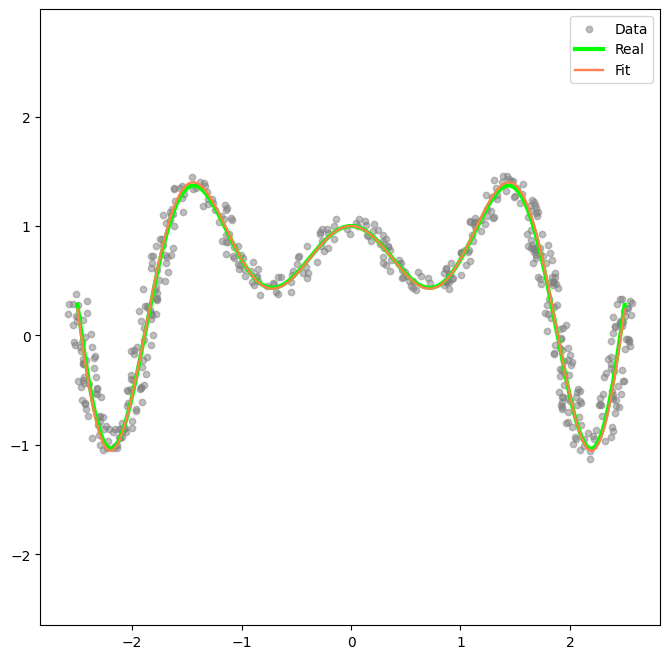

In [7]:
from matplotlib import pyplot as plt
import math
import copy
import numpy as np
from dataset_generator import Generator


class file_info_3d:
    def __init__(self, X=None, Y=None, f=None, x0=None):
        self.X = X
        self.Y = Y
        self.Z = np.vectorize(lambda x, y: f(np.array([x, y])))(X, Y)
        self.f = f
        self.x0 = x0


def print_lines_grad(file_info_3d, result, label, nth=1, title='Градиентный спуск на уровнях функции', filename='',
                     filename_extension='.png', dpi=512):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    list_result_nth = result[0::nth]

    if not np.array_equal(list_result_nth[-1], result[-1]):
        list_result_nth = np.vstack([list_result_nth, result[-1]])

    levels = np.unique(sorted([file_info_3d.f(p) for p in list_result_nth]))
    cs = ax.contour(file_info_3d.X, file_info_3d.Y, file_info_3d.Z, levels=levels, antialiased=True, linewidths=1.0, cmap='viridis')
    cs.clabel()

    x = list_result_nth[:, 0]
    y = list_result_nth[:, 1]
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', label=label, linewidth=2)
    print(
        f'{label:15} ==> '
        f'{file_info_3d.f(result[-1]):10f} in [{result[-1][0]:10f}, {result[-1][1]:10f}]')

    # Добавление заголовка и подписей осей
    if title != '':
        plt.title(title)

    # Добавление легенды
    if len(label) > 0:
        plt.legend(loc='upper left')

    if filename != '':
        plt.savefig(filename + '_lines' + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()


def func(X, Y, w, j):
    x = X[j]
    f = Y[j]

    return func_without_f(x, w) - f


def func_without_f(x, w):
    return w[0] * np.sin(x ** 2) + np.cos(w[1] * x)
    # return (1 - x * w[0]) ** 2 + 100 * (x * w[1] - x ** 2) ** 2


def objF(X, Y, w):
    obj = np.zeros(len(X))

    for i in range(len(X)):
        obj[i] = func(X, Y, w, i)

    return obj


def derivative(X, Y, w, i, j, delta=1e-6):
    w1 = np.copy(w)
    w2 = np.copy(w)

    w1[i] -= delta
    w2[i] += delta

    obj1 = func(X, Y, w1, j)
    obj2 = func(X, Y, w2, j)

    return (obj2 - obj1) / (2 * delta)


def jacobian(X, Y, w):
    rowNum = len(X)
    colNum = len(w)

    Jac = np.zeros((rowNum, colNum))

    for i in range(rowNum):
        for j in range(colNum):
            Jac[i][j] = derivative(X, Y, w, j, i)

    return Jac


def dog_leg(X, Y, initial_params, max_iter=1000, radius=1.0, e1=1e-12, e2=1e-12, e3=1e-12):
    result = [initial_params]
    current_params = np.copy(initial_params)

    obj = objF(X, Y, current_params)
    Jac = jacobian(X, Y, current_params)
    gradient = Jac.T @ obj

    if np.linalg.norm(obj) <= e3 or np.linalg.norm(gradient) <= e1:
        return

    for i in range(max_iter):
        obj = objF(X, Y, current_params)
        Jac = jacobian(X, Y, current_params)
        gradient = Jac.T @ obj

        if np.linalg.norm(gradient) <= e1:
            print("stop F'(x) = g(x) = 0 for a global minimizer optimizer.")
            break
        elif np.linalg.norm(obj) <= e3:
            print("stop f(x) = 0 for f(x) is so small")
            break

        alpha = np.linalg.norm(gradient, 2) / np.linalg.norm(Jac * gradient, 2)
        stepest_descent = -alpha * gradient
        gauss_newton = -1 * np.linalg.inv(Jac.T @ Jac) @ Jac.T @ obj

        beta = 0.0
        dog_leg = np.zeros(len(current_params))

        if np.linalg.norm(gauss_newton) <= radius:
            dog_leg = np.copy(gauss_newton)
        elif alpha * np.linalg.norm(stepest_descent) >= radius:
            dog_leg = (radius / np.linalg.norm(stepest_descent)) * stepest_descent
        else:
            a = alpha * stepest_descent
            b = np.copy(gauss_newton)
            c = a.T @ (b - a)

            if c <= 0:
                beta = (math.sqrt(
                    c * c + np.linalg.norm(b - a, 2) * (radius * radius - np.linalg.norm(a, 2))) - c) / np.linalg.norm(
                    b - a, 2)
            else:
                beta = (radius * radius - np.linalg.norm(a, 2)) / (
                        math.sqrt(c * c + np.linalg.norm(b - a, 2) * abs(radius * radius - np.linalg.norm(a, 2))) - c)
            dog_leg = alpha * stepest_descent + (gauss_newton - alpha * stepest_descent) * beta

        print(f'dog-leg: {dog_leg}')

        if np.linalg.norm(dog_leg) <= e2 * (np.linalg.norm(current_params) + e2):
            break

        new_params = current_params + dog_leg

        print(f'new parameter is: {new_params}\n')

        obj = objF(X, Y, current_params)
        obj_new = objF(X, Y, new_params)

        deltaF = np.linalg.norm(obj, 2) / 2 - np.linalg.norm(obj_new, 2) / 2

        delta_l = 0.0

        if np.linalg.norm(gauss_newton) <= radius:
            delta_l = np.linalg.norm(obj, 2) / 2
        elif alpha * np.linalg.norm(stepest_descent) >= radius:
            delta_l = radius * (2 * alpha * np.linalg.norm(gradient) - radius) / (2.0 * alpha)
        else:
            a = stepest_descent * alpha
            b = copy.copy(gauss_newton)
            c = a.T @ (b - a)

            if c <= 0:
                beta = (math.sqrt(
                    c * c + np.linalg.norm(b - a, 2) * (radius * radius - np.linalg.norm(a, 2))) - c) / np.linalg.norm(
                    b - a, 2)
            else:
                beta = (radius * radius - np.linalg.norm(a, 2)) / (
                        math.sqrt(c * c + np.linalg.norm(b - a, 2) * abs(radius * radius - np.linalg.norm(a, 2))) - c)

            delta_l = alpha * (1 - beta) * (1 - beta) * np.linalg.norm(gradient, 2) / 2.0 + beta * (2.0 - beta) * np.linalg.norm(obj, 2) / 2

        roi = deltaF / delta_l

        if roi > 0:
            current_params = np.copy(new_params)
        if roi > 0.75:
            radius = max(radius, 3.0 * np.linalg.norm(dog_leg))
        elif roi < 0.25:
            radius /= 2.0

            if radius <= e2 * (np.linalg.norm(current_params) + e2):
                print("trust region radius is too small.")
                break

        result.append(current_params)

    return result


def loss(w):
    return np.sum((Dataset_Y - func_without_f(Dataset_X, w)) ** 2)


# Generate synthetic data.
# PARAMETERS
density = 8000
dots_count = 500
variance = 0.1
dist = 2.5
radius = 0.8
weights = np.array([2, 3])
# ===========

gen = Generator(func_without_f)
X, Y, Dataset_X, Dataset_Y = gen.generate(dots_count, dist, density, variance, weights, absolute=False)

# Apply Gauss-Newton method.
max_iter = 10000
initial_w = np.array([3, 4], dtype=float)
result = dog_leg(Dataset_X, Dataset_Y, initial_w, max_iter=max_iter, radius=radius)

# Plot style:
plt.style.use('default')
_ = plt.figure(figsize=(8, 8))
# ===========

print(f"Result: {result[-1]}")
print(f'Loss value: {loss(result[-1])}')

plt.axis('equal')
plt.scatter(Dataset_X, Dataset_Y, label='Data', color='gray', alpha=0.5, s=20.8, antialiased=True)
plt.plot(X, Y, label='Real', color='lime', antialiased=True, linewidth=3)
plt.plot(X, func_without_f(X, result[-1]), label='Fit', color='coral', antialiased=True, linewidth=1.7)
plt.legend()
plt.show()


Powell Dog Leg  ==>  28.484050 in [  2.006459,   3.017929]


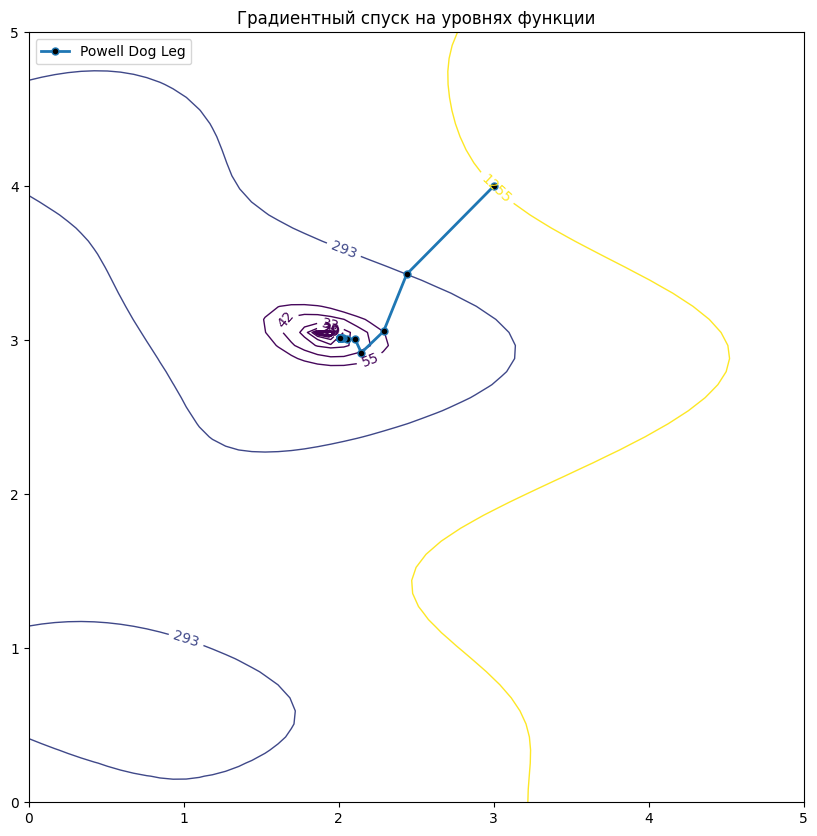

In [8]:
x_lin = np.linspace(0, 5, 60, dtype=float)
y_lin = np.linspace(0, 5, 60, dtype=float)
X, Y = np.meshgrid(x_lin, y_lin)

f_info = file_info_3d(X, Y, loss, initial_w)
print_lines_grad(f_info, np.array(result), 'Powell Dog Leg')